In [1]:
import pandas as pd
import os
import json
import torch
import numpy as np
from torch.utils.data import DataLoader
from steams.data import KVyQVx
from steams.models.transformer import EncoderTransformer2
from steams.trainer import AttentionTrainer,train, evaluation, prediction_prime, ensemble_prime
from steams.criterion import R2,RMSE,variance
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import geopandas as gpd

In [2]:
# parent_path = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))
# parent_dir = os.path.join(parent_path,'results','NWnn3')
# if not os.path.exists(parent_dir):
#     os.makedirs(parent_dir)

parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))


In [3]:
resdir = os.path.join(parent_dir,'results')
figdir = os.path.join(parent_dir,'fig')
if not os.path.exists(figdir):
    os.makedirs(figdir)
if not os.path.exists(resdir):
    os.makedirs(resdir)

In [5]:
if torch.cuda.is_available():
    cuda_name = "1"
    num_workers=0
    pin_memory = True
    device = torch.device('cuda'+":"+cuda_name)
    #device = torch.device('cuda')
else:
    num_workers = 4
    pin_memory = False
    device = torch.device('cpu')

In [6]:
device

device(type='cpu')

## train/valid dataset

In [7]:
params = {
        "class" : "KVyQVx",
        "Y":{
          "path": "",
          "KEY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "history_length": 0,
          "nb_sampling": 100
        },
        "X":{
          "path": "",
          "QUERY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "gap_length": 0,
          "horizon_length":0,
          "nb_sampling": 100
        }
    }

In [8]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_train")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_train")

train_dataset = KVyQVx(params)

In [9]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_valid")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_valid")

valid_dataset = KVyQVx(params)

In [10]:
#train_dataset[0]

## model, optimizer, criterion, scheduler

In [11]:
#model
model = EncoderTransformer2(input_k=2,input_q=2, input_v=1, hidden_size=32,dim_feedforward=10,num_blk=2,dropout=0.1)

In [12]:
# optimzer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #8e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# criterion
criterion = torch.nn.MSELoss()

# AttentionTrainer object
obj = AttentionTrainer(model,device)
obj.init_optimizer(optimizer)
obj.init_criterion(criterion)

## Training

In [13]:
# training
train(obj,train_dataset,valid_dataset,niter=200,n_iter_stop=10,batch_size=64,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

  epoch     train     valid
0     0  1.425774  1.221213
  epoch     train     valid
0     1  1.077399  0.873729
  epoch     train     valid
0     2  0.773808  0.633221
  epoch     train     valid
0     3  0.594756  0.500147
  epoch     train     valid
0     4  0.489027  0.423985
  epoch     train     valid
0     5  0.434898  0.384592
  epoch     train     valid
0     6  0.400584  0.352719
  epoch     train    valid
0     7  0.377548  0.33119
  epoch     train     valid
0     8  0.361853  0.316641
  epoch    train     valid
0     9  0.34695  0.307257
  epoch     train     valid
0    10  0.335622  0.294656
  epoch     train    valid
0    11  0.327039  0.28822
  epoch     train     valid
0    12  0.317549  0.280194
  epoch     train     valid
0    13  0.311209  0.274123
  epoch     train     valid
0    14  0.303542  0.265237
  epoch     train     valid
0    15  0.296376  0.253344
  epoch     train     valid
0    16  0.285398  0.242931
  epoch     train     valid
0    17  0.272808  0.22786

In [14]:
enc_attention_weights = torch.cat(model.attention_weights, 0)

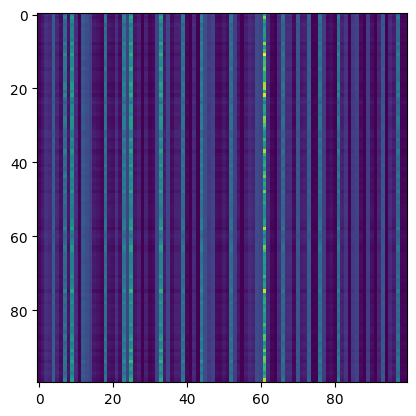

In [15]:
fig, ax = plt.subplots()
im = ax.imshow(enc_attention_weights[0])

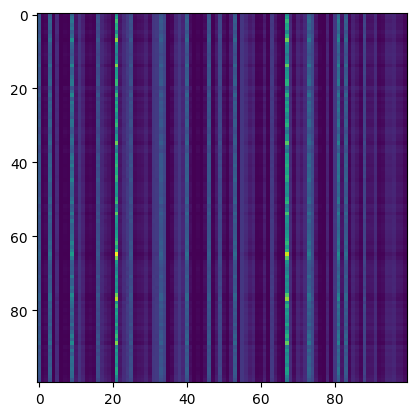

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(enc_attention_weights[1])

In [17]:
obj.save_model(resdir,"1d-transf_enc")

## Or load model

In [18]:
obj.load_model(resdir,"1d-transf_enc")

/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:265: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


## Evaluation

In [19]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [20]:
criterion = R2()
obj.init_criterion(criterion)

In [21]:
evaluation(obj,eval_dataset,batch_size=64,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.8905577398836613


In [22]:
criterion = RMSE()
obj.init_criterion(criterion)

In [23]:
evaluation(obj,eval_dataset,batch_size=64,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

38.23762011528015


In [24]:
criterion = variance()
obj.init_criterion(criterion)

In [25]:
evaluation(obj,eval_dataset,batch_size=64,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

853.2921562194824


## QQplot

In [26]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [27]:
results = prediction_prime(obj,eval_dataset)

/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,tmp_df],ignore_index=True,axis=0)


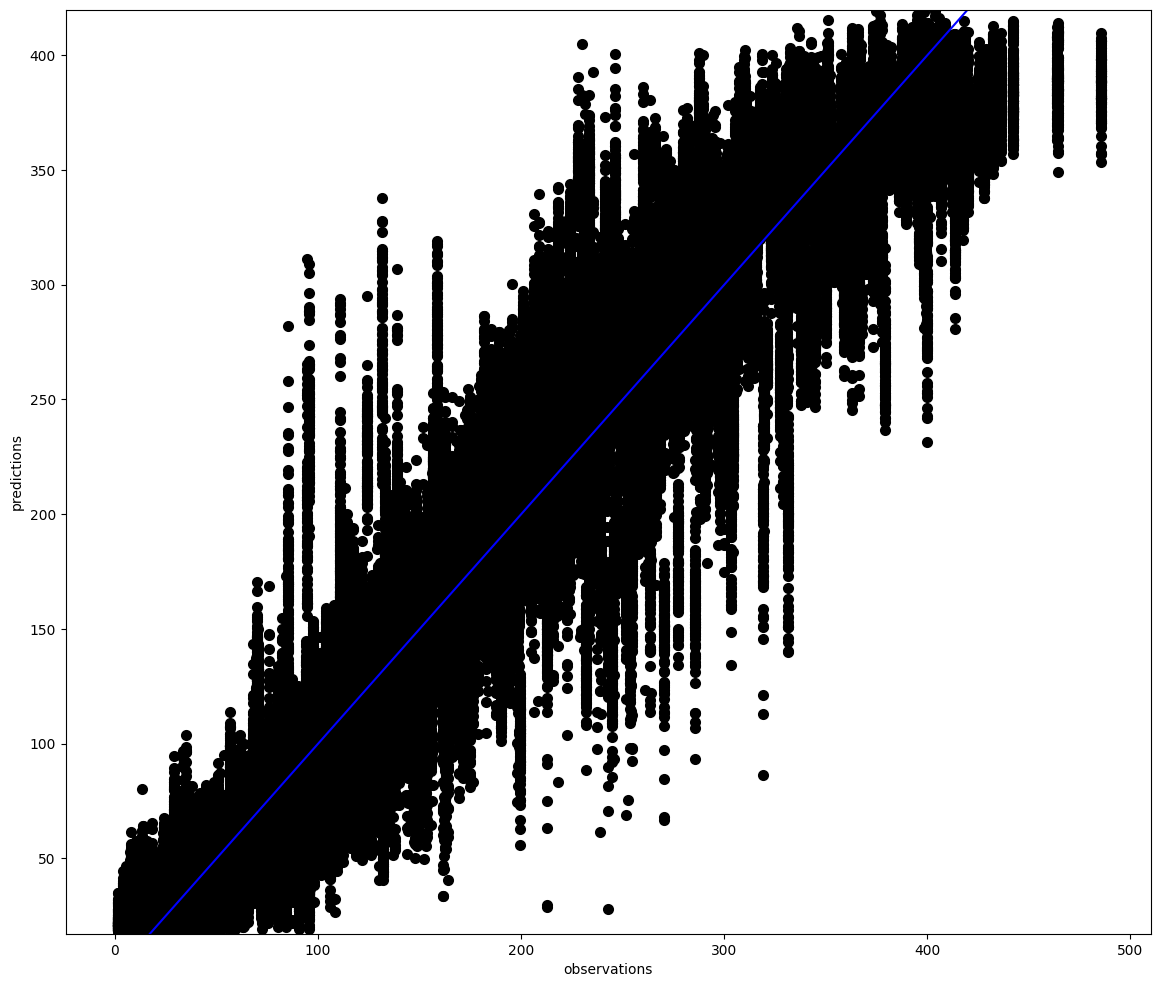

In [28]:
pred_name = ['pred_' + v for v in eval_dataset.VALUE_X]

fig, ax= plt.subplots(figsize=(14, 12))
ax.scatter(results.loc[:,eval_dataset.VALUE_X],results.loc[:,pred_name], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
# ax.set_xlim(0, 2.5)
ax.set_ylim(results.loc[:,pred_name].min().item()-0.5, results.loc[:,pred_name].max().item()+0.5)
ax.set(xlabel='observations', ylabel='predictions')

fig_filename = os.path.join(parent_dir,'fig','1c-qqplot.png')
plt.savefig(fig_filename, dpi = 300)

## Illustration of a 2d-map prediction

In [48]:
params = {
        "class" : "KVyQVx",
        "Y":{
          "path": "",
          "KEY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "history_length": 0,
          "nb_sampling": 1000
        },
        "X":{
          "path": "",
          "QUERY":["x","y"],
          "VALUE": ["ref"],
          "nb_location" : 6400,
          "gap_length": 0,
          "horizon_length":0,
          "nb_sampling": 1000
        }
    }

In [49]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_all_6400")

eval_dataset = KVyQVx(params)

In [50]:
eval_dataset[0][0].shape

torch.Size([1000, 2])

In [51]:
eval_dataset.scale(True)
KEY_Y,VALUE_Y,QUERY_X, VALUE_X = eval_dataset[0]


In [52]:
QUERY_res, VALUE_res = obj.predict(KEY_Y,VALUE_Y,QUERY_X,eval_dataset)

In [53]:
# output
VALUE_X = torch.reshape(VALUE_X,(1,VALUE_X.shape[0],VALUE_X.shape[1]))
#QUERY_X_unscale = eval_dataset.unscale(QUERY_X,"QUERY").to(device)
VALUE_X_unscale = eval_dataset.unscale(VALUE_X,"VALUE_X").to(device)

In [54]:
tmp = np.concatenate((QUERY_res, VALUE_res,VALUE_X_unscale),2)
tmp = np.reshape(tmp,(tmp.shape[1],tmp.shape[2]))
results = pd.DataFrame(tmp,columns=['x','y','values','truth'])   

In [55]:
# predictors
VALUE_Y = torch.reshape(VALUE_Y,(1,VALUE_Y.shape[0],VALUE_Y.shape[1]))
KEY_Y = torch.reshape(KEY_Y,(1,KEY_Y.shape[0],KEY_Y.shape[1]))
KEY_Y_unscale = eval_dataset.unscale(KEY_Y,"KEY").to(device)
VALUE_Y_unscale = eval_dataset.unscale(VALUE_Y,"VALUE_Y").to(device)

tmp = np.concatenate((KEY_Y_unscale, VALUE_Y_unscale),2)
tmp = np.reshape(tmp,(tmp.shape[1],tmp.shape[2]))
predictors = pd.DataFrame(tmp,columns=['x','y','values'])        

In [56]:
vmax = np.array(
    results['values'].max(),
    results['truth'].max()).max()

vmin = np.array(
    results['values'].min(),
    results['truth'].min()).min()

In [57]:
foo = predictors.copy()
# unique_rmse = np.unique(foo["rmse"])
# unique_variance = np.unique(foo["variance"])
# symbol_rmse = [i for i in range(1,len(unique_rmse)+1)]
# symbol_variance = ['o','v','s','p','s','D']#[i for i in range(len(unique_variance))]


In [58]:
# results

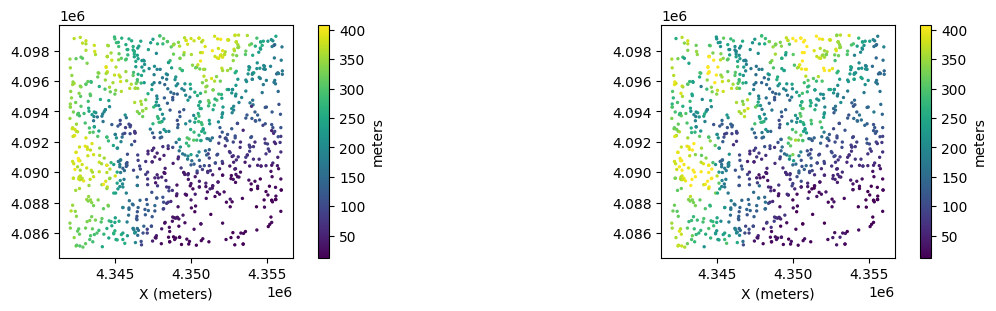

In [59]:
fig = plt.figure(constrained_layout=True,figsize=(12, 3))
gs = GridSpec(1, 2, figure=fig)

ax1 = fig.add_subplot(gs[0,0])
c1 = ax1.scatter(x=results["x"], y=results["y"], s=2,c=results['values'],vmin=vmin,vmax=vmax)
#ax1.set(ylabel='Y (meters)')
ax1.set(xlabel='X (meters)')
plt.gca().set_aspect("equal")

ax2 = fig.add_subplot(gs[0,1])
c2 = ax2.scatter(x=results["x"], y=results["y"], s=2,c=results['truth'],vmin=vmin,vmax=vmax)
#ax2.set(ylabel='Y (meters)')
ax2.set(xlabel='X (meters)')
plt.gca().set_aspect("equal")

fig.colorbar(c1, ax=ax1,label ='meters')
fig.colorbar(c2, ax=ax2,label ='meters')

fig_filename = os.path.join(parent_dir,'fig','illustration_prediction.png')
plt.savefig(fig_filename, dpi = 300)
